# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import seaborn as sns
from scipy.interpolate import interp1d
import pitszi
import minot
from pitszi import physics_main as phys

import macsj0717_libs as libs

# Useful functions

In [2]:
def seaborn_1d(chains, output_fig=None, ci=0.68, truth=None, label=None,
               gridsize=100, alpha=(0.2, 0.4), xlim=None, bins=30,
               figsize=(10,10), fontsize=12, names=None,
               cols=[('blue','grey', 'orange')]):
    '''
    This function plots 1D distributions of MC chains
    
    Parameters:
    - chain (array): the chains sampling the considered parameter
    - output_fig (str): full path to output plot
    - ci (float): confidence interval considered
    - truth (float): the expected truth for overplot
    - label (str): the label of the parameter
    - gridsize (int): the size of the kde grid
    - alpha (tupple): alpha values for the histogram and the 
    overplotted confidence interval
    - figsize (tupple): the size of the figure
    - fontsize (int): the font size
    - cols (tupple): the colors of the histogram, confidence interval 
    values, and confidence interval filled region
    Output:
    - Plots
    '''
    
    fig = plt.figure(0, figsize=(8, 6))
    #----- initial plots of histograms + kde
    for idx, ch in enumerate(chains, start=0):
        sns.histplot(ch, kde=True, kde_kws={'cut':3}, color=cols[idx][0], edgecolor=cols[idx][1], 
                     alpha=alpha[0], stat='density', binrange=xlim, bins=bins)
    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    
    #----- show limits
    for idx, ch in enumerate(chains, start=0):
        if ci is not None:
            perc = np.percentile(ch, [100 - (100-ci*100)/2.0, 50.0, (100-ci*100)/2.0])
            # Get the KDE line for filling below
            xkde = ax.lines[idx].get_xdata()
            ykde = ax.lines[idx].get_ydata()
            wkeep = (xkde < perc[0]) * (xkde > perc[2])
            xkde_itpl = np.append(np.append(perc[2], xkde[wkeep]), perc[0])
            itpl = interp1d(xkde, ykde)
            ykde_itpl = itpl(xkde_itpl)
            perc_max = itpl(perc)
            
            ax.vlines(perc[0], 0.0, perc_max[0], linestyle='--', color=cols[idx][1])
            ax.vlines(perc[2], 0.0, perc_max[2], linestyle='--', color=cols[idx][1])
            
            if idx == 0:
                ax.vlines(perc[1], 0.0, perc_max[1], linestyle='-.', label='Median', color=cols[idx][1])
            else:
                ax.vlines(perc[1], 0.0, perc_max[1], linestyle='-.', color=cols[idx][1])
            if names is not None:
                ax.fill_between(xkde_itpl, 0*ykde_itpl, y2=ykde_itpl, alpha=alpha[1], 
                                color=cols[idx][2], label=names[idx])
            else:
                ax.fill_between(xkde_itpl, 0*ykde_itpl, y2=ykde_itpl, alpha=alpha[1], 
                                color=cols[idx][2])
    # Show expected value                        
    if truth is not None:
        ax.vlines(truth, 0, ymax, linestyle=':', label='Truth', color='k')
    
    # label and ticks
    if label is not None:
        ax.set_xlabel(label)
        ax.set_ylabel('P('+label+')')
    ax.set_yticks([])
    ax.set_ylim(0, ymax)
    
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
               
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
               
    ax.legend(fontsize=fontsize)
    
    if output_fig is not None:
        #plt.tight_layout()
        plt.savefig(output_fig, bbox_inches = 'tight')

In [3]:
#----- Init the objects to have access to prior function only
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(4*u.arcmin, 4*u.arcsec, 0.1)
cl_data  = libs.def_data(cl_img, cl_head, cl_noise, cl_mask, 18.2*u.arcsec, libs.get_TF(), '', 1)
cl_model = pitszi.Model(RA=109.3806*u.deg, Dec=37.7583*u.deg, silent=True)
cl_model.map_header = cl_head
cl_Finfer = pitszi.InferenceFluctuation(cl_data, cl_model, silent=True)

def fake_chains_curvefit(parinfo, popt, pcov, Nsample=10000):
    par_chains = np.zeros((Nsample, len(popt)))
    isamp = 0
    while isamp < Nsample:
        param = np.random.multivariate_normal(popt, pcov)
        cond = np.isfinite(cl_Finfer.prior_fluctuation(param, parinfo))
        if cond:
            par_chains[isamp,:] = param
            isamp += 1
    return par_chains[np.newaxis]

# Parameters

In [4]:
base = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

In [5]:
include_scatter = True
Nmc = 10000

cl_redshift = 0.546
cl_M500     = 26.5*1e14*u.Msun

Tgas = 15*u.keV
cs = phys.sound_speed(Tgas)
print(cs)

1981.3508758974326 km / s


# Get the fit data

In [6]:
with open(base+'Pk_constraint_RM1_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist1 = np.load(f, allow_pickle=True)
    popt1 = np.load(f, allow_pickle=True)
    pcov1 = np.load(f, allow_pickle=True)
with open(base+'Pk_constraint_RM2_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist2 = np.load(f, allow_pickle=True)
    popt2 = np.load(f, allow_pickle=True)
    pcov2 = np.load(f, allow_pickle=True)
with open(base+'Pk_constraint_RM3_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist3 = np.load(f, allow_pickle=True)
    popt3 = np.load(f, allow_pickle=True)
    pcov3 = np.load(f, allow_pickle=True)
with open(base+'Pk_constraint_RM4_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist4 = np.load(f, allow_pickle=True)
    popt4 = np.load(f, allow_pickle=True)
    pcov4 = np.load(f, allow_pickle=True)
with open(base+'Pk_constraint_RM5_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist5 = np.load(f, allow_pickle=True)
    popt5 = np.load(f, allow_pickle=True)
    pcov5 = np.load(f, allow_pickle=True)

# Analysis

In [7]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[50, 5000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 5]},
    'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0, 5]},
}

In [8]:
cl_model = pitszi.Model(name='Model', redshift=cl_redshift, M500=cl_M500, silent=True, output_dir=base)
cl_model.set_pressure_profile_universal_param('A10MD')

In [9]:
parlist = [popt1, popt2, popt3, popt4, popt5]
covlist = [pcov1, pcov2, pcov3, pcov4, pcov5]
ell     = [False, False, True, True, True]

MC_Akpeak  = np.zeros((5,Nmc))
MC_M3dG14  = np.zeros((5,Nmc))
MC_M3dZ23  = np.zeros((5,Nmc))
MC_sigma_v = np.zeros((5,Nmc))
MC_X       = np.zeros((5,Nmc))
MC_Eratio  = np.zeros((5,Nmc))

for ipars in range(len(parlist)):
    pars = parlist[ipars]
    cl_model.model_pressure_fluctuation['Norm'] = pars[0]
    cl_model.model_pressure_fluctuation['Linj'] = pars[1]*u.kpc
    k, pk = cl_model.get_pressure_fluctuation_spectrum()    
    Akpeak = np.amax(np.sqrt(4*np.pi*k**3*pk).to_value(''))

    #----- Best fit plus scatter on the M3d-Pk relation
    print('----- Best fit power spectrum plus scatter in Pk-M3D')
    print('Apeak', Akpeak)
    M3d = phys.Apeak_to_M3d_G13(Akpeak, Linj=cl_model.model_pressure_fluctuation['Linj'])
    print('M3d G14', M3d)
    M3d, Merr = phys.sigma_to_M3d_Z23(cl_model.model_pressure_fluctuation['Norm'], state='unrelaxed', ell=ell[ipars], ret_err=True)
    print('M3d Z23', M3d, Merr)
    sigma_v = phys.sigma_v(cs, M3d)
    print('sigma_v Z23', sigma_v, sigma_v*Merr/M3d)
    X_l = phys.Eturb_over_Etherm(M3d-Merr)
    X_c = phys.Eturb_over_Etherm(M3d)
    X_u = phys.Eturb_over_Etherm(M3d+Merr)
    Eratio_l = 1/(1+1/X_l)
    Eratio_c = 1/(1+1/X_c)
    Eratio_u = 1/(1+1/X_u)
    print('Ek/Eth+k ', Eratio_c, '+', Eratio_u-Eratio_c, '-', Eratio_c-Eratio_l)
    print('')

    #----- With statistical uncertainties from the power spectrum
    k3d = np.logspace(-4,-1,100)*u.kpc**-1
    chains = fake_chains_curvefit(fitpar_pk3d, parlist[ipars], covlist[ipars], Nsample=Nmc)
    for imc in range(Nmc):
        cl_model.model_pressure_fluctuation['Norm'] = chains[0][imc,0]
        cl_model.model_pressure_fluctuation['Linj'] = chains[0][imc,1]*u.kpc
        MC_k, MC_pk = cl_model.get_pressure_fluctuation_spectrum()

        MC_Akpeak[ipars,imc] = np.amax(np.sqrt(4*np.pi*MC_k**3*MC_pk).to_value(''))
        MC_M3dG14[ipars,imc] = phys.Apeak_to_M3d_G13(MC_Akpeak[ipars,imc], Linj=cl_model.model_pressure_fluctuation['Linj'])
        M3d_imc, Merr_imc = phys.sigma_to_M3d_Z23(cl_model.model_pressure_fluctuation['Norm'], state='unrelaxed', ell=ell[ipars], ret_err=True)
        if include_scatter: 
            MC_M3dZ23[ipars,imc] = np.random.normal(M3d_imc, Merr_imc)
        else:
            MC_M3dZ23[ipars,imc] = np.random.normal(M3d_imc, 0)
        MC_sigma_v[ipars,imc] = phys.sigma_v(cs, MC_M3dZ23[ipars,imc]).value
        MC_X[ipars,imc] = phys.Eturb_over_Etherm(MC_M3dZ23[ipars,imc])
        MC_Eratio[ipars,imc] = 1/(1+1/MC_X[ipars,imc])

    print('----- MC power spectrum uncertainties plus scatter in Pk-M3D as Gaussian error (median and 68% CL given)')
    perc = np.percentile(MC_M3dZ23[ipars], [(100-0.68*100)/2.0, 50.0, 100 - (100-0.68*100)/2.0])
    print('M3d Z23', perc[1],'+', perc[2]-perc[1], '-', perc[1]-perc[0])
    perc = np.percentile(MC_sigma_v[ipars], [(100-0.68*100)/2.0, 50.0, 100 - (100-0.68*100)/2.0])
    print('sigma_v Z23', perc[1],'+', perc[2]-perc[1], '-', perc[1]-perc[0])
    perc = np.percentile(MC_Eratio[ipars], [(100-0.68*100)/2.0, 50.0, 100 - (100-0.68*100)/2.0])
    print('Ek/Eth+k ', perc[1],'+', perc[2]-perc[1], '-', perc[1]-perc[0])
    print('')
    print('=====')

----- Best fit power spectrum plus scatter in Pk-M3D
Apeak 0.6948720098096717
M3d G14 0.9378125924269326
M3d Z23 0.8802313324608223 0.17604626649216445
sigma_v Z23 1744.0471215636144 km / s 348.80942431272285 km / s
Ek/Eth+k  0.3009185305421207 + 0.08173874130280678 - 0.08493279089365888

----- MC power spectrum uncertainties plus scatter in Pk-M3D as Gaussian error (median and 68% CL given)
M3d Z23 0.8177854918921594 + 0.17313705888526976 - 0.17010501114064702
sigma_v Z23 1620.3200006567429 + 343.04526327263466 - 337.0377128180635
Ek/Eth+k  0.270892901312433 + 0.08207370216848381 - 0.08189001986992883

=====
----- Best fit power spectrum plus scatter in Pk-M3D
Apeak 0.4010960770790296
M3d G14 0.8442215356732934
M3d Z23 0.6242805866446457 0.12485611732892914
sigma_v Z23 1236.9188871541319 km / s 247.3837774308264 km / s
Ek/Eth+k  0.1779794395340854 + 0.059698191507468995 - 0.056274656570499196

----- MC power spectrum uncertainties plus scatter in Pk-M3D as Gaussian error (median and 6

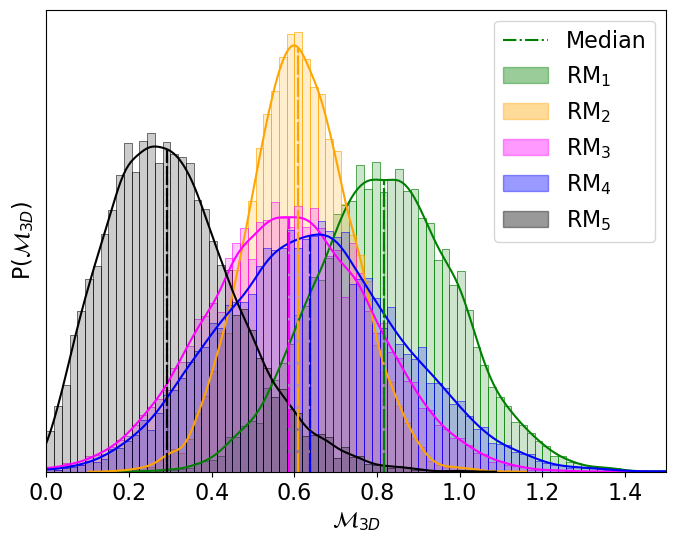

In [10]:
seaborn_1d(np.array([MC_M3dZ23[0], MC_M3dZ23[1], MC_M3dZ23[2], MC_M3dZ23[3], MC_M3dZ23[4]]), 
           output_fig=base+'/PDF_M3D_scatter'+str(include_scatter)+'.pdf', ci=0.0, truth=None, label=r'$\mathcal{M}_{3D}$',
           names=['RM$_1$', 'RM$_2$', 'RM$_3$', 'RM$_4$', 'RM$_5$'],
           alpha=(0.2, 0.4), 
           figsize=(10,10), fontsize=16, xlim=[0,1.5], bins=80,
           cols=[('green','green','green'), 
                 ('orange','orange','orange'), 
                 ('magenta','magenta','magenta'), 
                 ('blue','blue','blue'), 
                 ('k','k','k')])

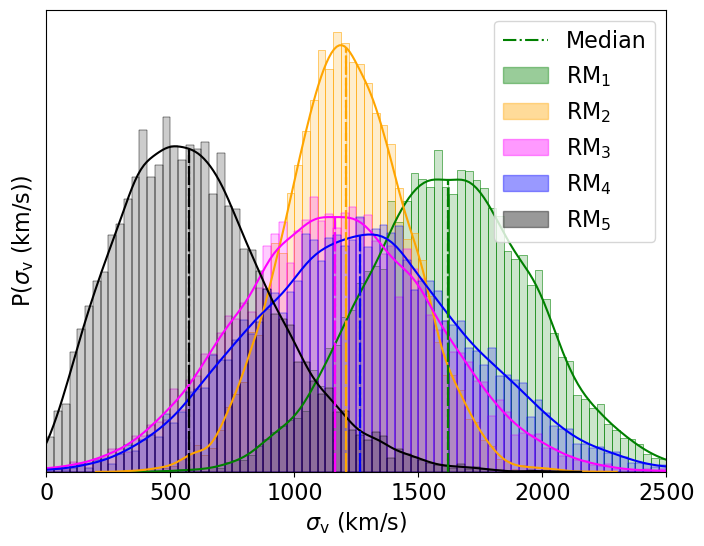

In [11]:
seaborn_1d(np.array([MC_sigma_v[0], MC_sigma_v[1], MC_sigma_v[2], MC_sigma_v[3], MC_sigma_v[4]]), 
           output_fig=base+'/PDF_sigmaV_scatter'+str(include_scatter)+'.pdf', ci=0.0, truth=None, label=r'$\sigma_{\rm v}$ (km/s)',
           names=['RM$_1$', 'RM$_2$', 'RM$_3$', 'RM$_4$', 'RM$_5$'],
           alpha=(0.2, 0.4), 
           figsize=(10,10), fontsize=16, xlim=[0,2500], bins=80,
           cols=[('green','green','green'), 
                 ('orange','orange','orange'), 
                 ('magenta','magenta','magenta'), 
                 ('blue','blue','blue'), 
                 ('k','k','k')])

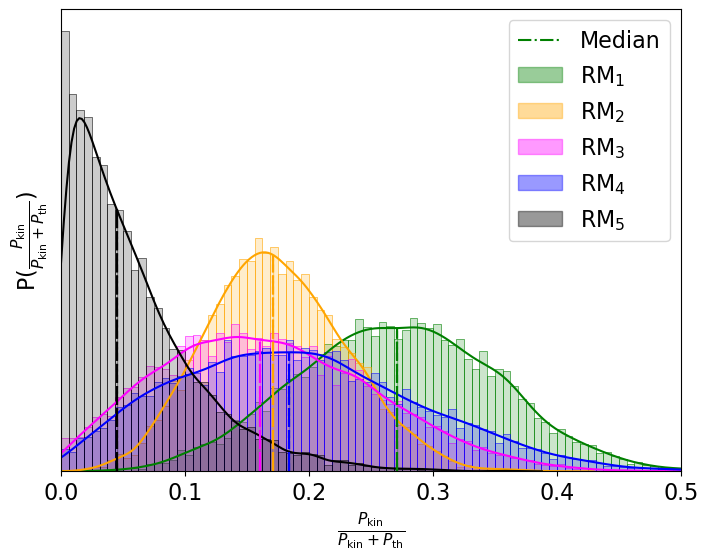

In [12]:
seaborn_1d(np.array([MC_Eratio[0], MC_Eratio[1], MC_Eratio[2], MC_Eratio[3], MC_Eratio[4]]), 
           output_fig=base+'/PDF_Pratio_scatter'+str(include_scatter)+'.pdf', ci=0.0, truth=None, label=r'$\frac{P_{\rm kin}}{P_{\rm kin} + P_{\rm th}}$',
           names=['RM$_1$', 'RM$_2$', 'RM$_3$', 'RM$_4$', 'RM$_5$'],
           alpha=(0.2, 0.4), 
           figsize=(10,10), fontsize=16, xlim=[0,0.5], bins=80,
           cols=[('green','green','green'), 
                 ('orange','orange','orange'), 
                 ('magenta','magenta','magenta'), 
                 ('blue','blue','blue'), 
                 ('k','k','k')])

# Comparison with X-ray fluctuations

In [13]:
cl_model = pitszi.Model(name='Model', redshift=cl_redshift, M500=cl_M500, silent=True, output_dir=base)
cl_model.set_pressure_profile_universal_param('A10MD')

----- Best fit power spectra
Akpeak:  0.6948720098096717
Ak=1/R2500:  0.4573555283231932
----- MC power spectra with error
Akpeak:  0.6170749686090442 + 0.052180383041802614 - 0.061516771740479426
Ak=1/R2500:  0.47135014236433737 + 0.0427721264362082 - 0.017157472977718524

----- Best fit power spectra
Akpeak:  0.4010960770790296
Ak=1/R2500:  0.40089651742475124
----- MC power spectra with error
Akpeak:  0.3886612771481615 + 0.020489169251194927 - 0.019432030397907862
Ak=1/R2500:  0.3879140160984571 + 0.019877390372828874 - 0.01906459511997305

----- Best fit power spectra
Akpeak:  0.3801687946111237
Ak=1/R2500:  0.3798468945909748
----- MC power spectra with error
Akpeak:  0.3674581888492347 + 0.019922015730997 - 0.019848319947906257
Ak=1/R2500:  0.36684257315762503 + 0.019156103564277882 - 0.01965355074982772

----- Best fit power spectra
Akpeak:  0.4412148714083557
Ak=1/R2500:  0.4236362066303405
----- MC power spectra with error
Akpeak:  0.41955821843455676 + 0.0442849277372922 - 0

(0.1, 1)

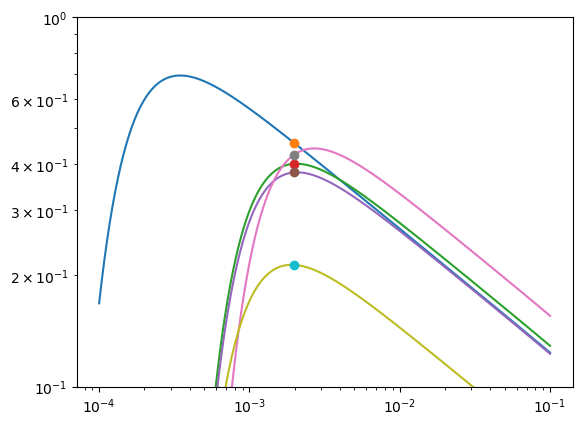

In [14]:
for ipars in range(len(parlist)):
    pars = parlist[ipars]
    
    print('----- Best fit power spectra')
    cl_model.model_pressure_fluctuation['Norm'] = pars[0]
    cl_model.model_pressure_fluctuation['Linj'] = pars[1]*u.kpc
    k,pk = cl_model.get_pressure_fluctuation_spectrum()
    k2500,pk2500 = cl_model.get_pressure_fluctuation_spectrum(1/(507*u.kpc))
    plt.loglog(k.to_value('kpc-1'), np.sqrt(4*np.pi*k**3*pk).to_value(''))
    plt.plot(k2500.to_value('kpc-1'), np.sqrt(4*np.pi*k2500**3*pk2500).to_value(''), marker='o', ls='')
    print('Akpeak: ', np.amax(np.sqrt(4*np.pi*k**3*pk).to_value('')))
    print('Ak=1/R2500: ', np.sqrt(4*np.pi*k2500**3*pk2500).to_value('')[0])

    print('----- MC power spectra with error')
    k3d = np.logspace(-4,-1,100)*u.kpc**-1
    chains = fake_chains_curvefit(fitpar_pk3d, parlist[ipars], covlist[ipars])
    MC_peak = np.zeros((1000))
    MC_2500 = np.zeros((1000))
    for imc in range(1000):
        cl_model.model_pressure_fluctuation['Norm'] = chains[0][imc,0]
        cl_model.model_pressure_fluctuation['Linj'] = chains[0][imc,1]*u.kpc
        MC_k, MC_pk         = cl_model.get_pressure_fluctuation_spectrum()
        MC_k2500, MC_pk2500 = cl_model.get_pressure_fluctuation_spectrum(1/(507*u.kpc))
        MC_peak[imc] = np.amax(np.sqrt(4*np.pi*MC_k**3*MC_pk).to_value(''))
        MC_2500[imc] = np.sqrt(4*np.pi*MC_k2500**3*MC_pk2500).to_value('')[0]

    perc = np.percentile(MC_peak, [(100-0.68*100)/2.0, 50.0, 100 - (100-0.68*100)/2.0])
    print('Akpeak: ', perc[1],'+', perc[2]-perc[1], '-', perc[1]-perc[0])
    perc = np.percentile(MC_2500, [(100-0.68*100)/2.0, 50.0, 100 - (100-0.68*100)/2.0])
    print('Ak=1/R2500: ', perc[1],'+', perc[2]-perc[1], '-', perc[1]-perc[0])
    print('')

plt.ylim(0.1,1)

In [15]:
dpp = np.array([0.47131476146728357, 0.38921942232682394, 0.3675931610678197, 0.401683247051386, 0.1526043686721359])
dpp_errP = np.array([0.041490126167847974, 0.01932177799864998, 0.0183624151208015, 0.03370365155861188, 0.0637053736470537])
dpp_errM = np.array([0.016727339015858933, 0.02015962119762299, 0.020293591639156172, 0.0362648449747478, 0.059956502981446586])

drr = 32.9/100
drr_errP = 16.4/100
drr_errM = 11.0/100

gamma = dpp / drr
gamma_errM = (dpp_errP**2 / drr**2 + dpp**2 * drr_errM**2 / drr**4)**0.5
gamma_errP = (dpp_errM**2 / drr**2 + dpp**2 * drr_errP**2 / drr**4)**0.5
print('Gamma = ', gamma)
print('+', gamma_errP)
print('-', gamma_errM)
print()
gamma_U = (dpp+dpp_errP) / (drr-drr_errM)
gamma_L = (dpp-dpp_errM) / (drr+drr_errP)
print('Gamma = ', gamma)
print('+', gamma_U-gamma)
print('-', gamma-gamma_L)
print()
print('gamma \in ', gamma-gamma_errM, gamma+gamma_errP)
print('gamma \in ', gamma_L, gamma_U)

5/3

Gamma =  [1.43256766 1.18303776 1.11730444 1.22092172 0.46384307]
+ [0.71591435 0.59289584 0.56035945 0.61850674 0.29440114]
- [0.49529766 0.39988068 0.37771318 0.42086893 0.24808268]

Gamma =  [1.43256766 1.18303776 1.11730444 1.22092172 0.46384307]
+ [0.90900717 0.68244718 0.64504979 0.76714631 0.52387265]
- [0.51048364 0.43443776 0.41284284 0.47970793 0.27591636]

gamma \in  [0.93727001 0.78315708 0.73959126 0.80005279 0.21576038] [2.14848201 1.7759336  1.6776639  1.83942846 0.7582442 ]
gamma \in  [0.92208402 0.7486     0.7044616  0.7412138  0.18792671] [2.34157483 1.86548493 1.76235423 1.98806803 0.98771572]


1.6666666666666667

# Extracting kSZ los velocity rms

In [16]:
vz_map_file1 = '/Users/adam/Project/Notes-Papier-Conf/2015_10_MACSJ0717_Paper/IDL/Save/MACSJ0717_vz_F1_alt.fits'
vz_map_file2 = '/Users/adam/Project/Notes-Papier-Conf/2015_10_MACSJ0717_Paper/IDL/Save/MACSJ0717_vz_F2_alt.fits'
vz_map_file3 = '/Users/adam/Project/Notes-Papier-Conf/2015_10_MACSJ0717_Paper/IDL/Save/MACSJ0717_vz_via_leff.fits'

hdul1 = fits.open(vz_map_file1)[0]
hdul2 = fits.open(vz_map_file2)[0]
hdul3 = fits.open(vz_map_file3)[0]

w1 = (hdul1.data < 10000) * (hdul1.data > -10000) * (~np.isnan(hdul1.data))
w2 = (hdul2.data < 10000) * (hdul2.data > -10000) * (~np.isnan(hdul2.data))
w3 = (hdul3.data < 10000) * (hdul3.data > -10000) * (~np.isnan(hdul3.data))

print(np.std(hdul1.data[w1]))
print(np.std(hdul2.data[w2]))
print(np.std(hdul3.data[w3]))

1554.9618
1314.7079
1204.4984734137897


# NT profiles

In [17]:
cl_model = minot.Cluster(redshift=cl_redshift, M500=cl_M500, silent=True)
cl_model.set_pressure_gas_universal_param('A10MD')

radius = np.logspace(1,4,100)
include_scatter = True

In [18]:
case='sum'
MC_Eratio  = np.zeros((5, 1000, len(radius)))
for ipars in range(len(parlist)):
    k3d = np.logspace(-4,-1,100)*u.kpc**-1
    chains = fake_chains_curvefit(fitpar_pk3d, parlist[ipars], covlist[ipars])
    for imc in range(1000):
        M3d_r, M3d_r_err = phys.sigma_rad_to_M3d_Z23(chains[0][imc,0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
        if include_scatter: 
            MC_M3d = M3d_r + M3d_r_err*np.random.normal(0, 1)
        else:
            MC_M3d = M3d_r
        X = phys.Eturb_over_Etherm(MC_M3d)

        MC_Eratio[ipars,imc,:] = 1/(1+1/X)

Eratio_l1 = np.percentile(MC_Eratio[0,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c1 = np.percentile(MC_Eratio[0,:,:], 50.0, axis=0)
Eratio_u1 = np.percentile(MC_Eratio[0,:,:], 100 - (100-0.68*100)/2.0, axis=0)

Eratio_l2 = np.percentile(MC_Eratio[1,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c2 = np.percentile(MC_Eratio[1,:,:], 50.0, axis=0)
Eratio_u2 = np.percentile(MC_Eratio[1,:,:], 100 - (100-0.68*100)/2.0, axis=0)

Eratio_l3 = np.percentile(MC_Eratio[2,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c3 = np.percentile(MC_Eratio[2,:,:], 50.0, axis=0)
Eratio_u3 = np.percentile(MC_Eratio[2,:,:], 100 - (100-0.68*100)/2.0, axis=0)

Eratio_l4 = np.percentile(MC_Eratio[3,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c4 = np.percentile(MC_Eratio[3,:,:], 50.0, axis=0)
Eratio_u4 = np.percentile(MC_Eratio[3,:,:], 100 - (100-0.68*100)/2.0, axis=0)

Eratio_l5 = np.percentile(MC_Eratio[4,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c5 = np.percentile(MC_Eratio[4,:,:], 50.0, axis=0)
Eratio_u5 = np.percentile(MC_Eratio[4,:,:], 100 - (100-0.68*100)/2.0, axis=0)

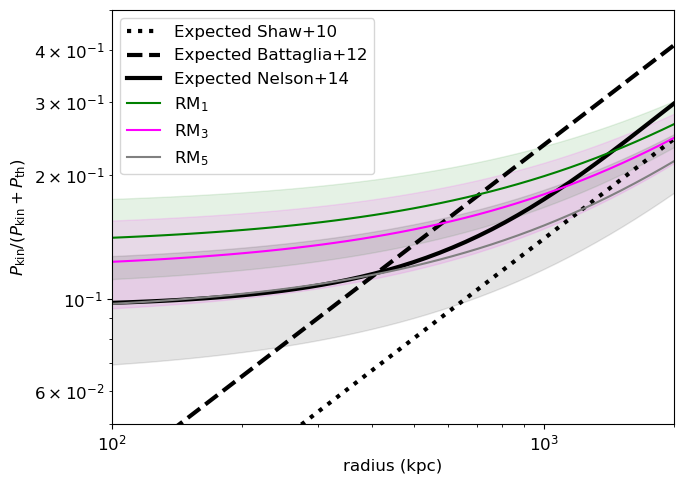

In [19]:
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(0, figsize=(7, 5))
plt.plot(radius, phys.pnt_over_ptot_r_S10(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls=':',  label='Expected Shaw+10')
plt.plot(radius, phys.pnt_over_ptot_r_B11(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls='--', label='Expected Battaglia+12')
plt.plot(radius, phys.pnt_over_ptot_r_N14(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls='-',  label='Expected Nelson+14')

plt.plot(radius, Eratio_c1, color='green', label='RM$_1$')
plt.fill_between(radius, Eratio_l1, Eratio_u1, color='green', alpha=0.1)

#plt.plot(radius, Eratio_c2, color='orange', label='RM$_2$')
#plt.fill_between(radius, Eratio_l2, Eratio_u2, color='orange', alpha=0.1)

plt.plot(radius, Eratio_c3, color='magenta', label='RM$_3$')
plt.fill_between(radius, Eratio_l3, Eratio_u3, color='magenta', alpha=0.1)

#plt.plot(radius, Eratio_c4, color='blue', label='RM$_4$')
#plt.fill_between(radius, Eratio_l4, Eratio_u4, color='blue', alpha=0.1)

plt.plot(radius, Eratio_c5, color='grey', label='RM$_5$')
plt.fill_between(radius, Eratio_l5, Eratio_u5, color='k', alpha=0.1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,2000)
plt.ylim(0.05,0.5)
plt.xlabel('radius (kpc)')
plt.ylabel(r'$P_{\rm kin} / \left(P_{\rm kin} + P_{\rm th}\right)$')

plt.savefig(base+'NT_phys_sum.pdf')

In [20]:
case='prod'
MC_Eratio  = np.zeros((5, 1000, len(radius)))
for ipars in range(len(parlist)):
    k3d = np.logspace(-4,-1,100)*u.kpc**-1
    chains = fake_chains_curvefit(fitpar_pk3d, parlist[ipars], covlist[ipars])
    for imc in range(1000):
        M3d_r, M3d_r_err = phys.sigma_rad_to_M3d_Z23(chains[0][imc,0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
        if include_scatter: 
            MC_M3d = M3d_r + M3d_r_err*np.random.normal(0, 1)
        else:
            MC_M3d = M3d_r
        X = phys.Eturb_over_Etherm(MC_M3d)

        MC_Eratio[ipars,imc,:] = 1/(1+1/X)

Eratio_l1 = np.percentile(MC_Eratio[0,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c1 = np.percentile(MC_Eratio[0,:,:], 50.0, axis=0)
Eratio_u1 = np.percentile(MC_Eratio[0,:,:], 100 - (100-0.68*100)/2.0, axis=0)

Eratio_l2 = np.percentile(MC_Eratio[1,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c2 = np.percentile(MC_Eratio[1,:,:], 50.0, axis=0)
Eratio_u2 = np.percentile(MC_Eratio[1,:,:], 100 - (100-0.68*100)/2.0, axis=0)

Eratio_l3 = np.percentile(MC_Eratio[2,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c3 = np.percentile(MC_Eratio[2,:,:], 50.0, axis=0)
Eratio_u3 = np.percentile(MC_Eratio[2,:,:], 100 - (100-0.68*100)/2.0, axis=0)

Eratio_l4 = np.percentile(MC_Eratio[3,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c4 = np.percentile(MC_Eratio[3,:,:], 50.0, axis=0)
Eratio_u4 = np.percentile(MC_Eratio[3,:,:], 100 - (100-0.68*100)/2.0, axis=0)

Eratio_l5 = np.percentile(MC_Eratio[4,:,:], (100-0.68*100)/2.0, axis=0)
Eratio_c5 = np.percentile(MC_Eratio[4,:,:], 50.0, axis=0)
Eratio_u5 = np.percentile(MC_Eratio[4,:,:], 100 - (100-0.68*100)/2.0, axis=0)

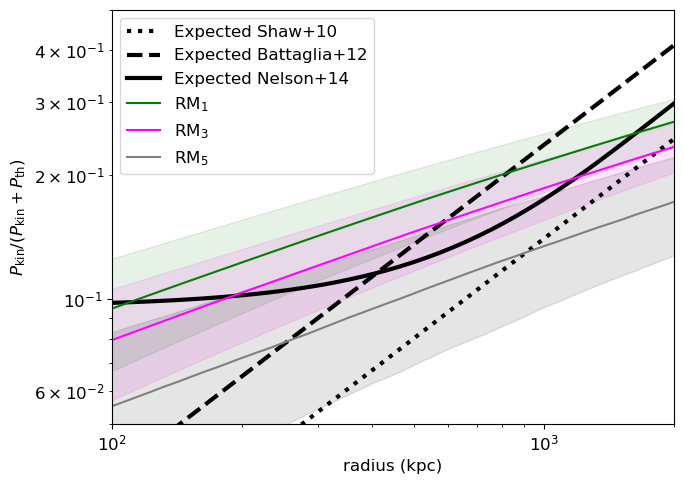

In [21]:
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(0, figsize=(7, 5))
plt.plot(radius, phys.pnt_over_ptot_r_S10(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls=':',  label='Expected Shaw+10')
plt.plot(radius, phys.pnt_over_ptot_r_B11(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls='--', label='Expected Battaglia+12')
plt.plot(radius, phys.pnt_over_ptot_r_N14(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls='-',  label='Expected Nelson+14')

plt.plot(radius, Eratio_c1, color='green', label='RM$_1$')
plt.fill_between(radius, Eratio_l1, Eratio_u1, color='green', alpha=0.1)

#plt.plot(radius, Eratio_c2, color='orange', label='RM$_2$')
#plt.fill_between(radius, Eratio_l2, Eratio_u2, color='orange', alpha=0.1)

plt.plot(radius, Eratio_c3, color='magenta', label='RM$_3$')
plt.fill_between(radius, Eratio_l3, Eratio_u3, color='magenta', alpha=0.1)

#plt.plot(radius, Eratio_c4, color='blue', label='RM$_4$')
#plt.fill_between(radius, Eratio_l4, Eratio_u4, color='blue', alpha=0.1)

plt.plot(radius, Eratio_c5, color='grey', label='RM$_5$')
plt.fill_between(radius, Eratio_l5, Eratio_u5, color='k', alpha=0.1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,2000)
plt.ylim(0.05,0.5)
plt.xlabel('radius (kpc)')
plt.ylabel(r'$P_{\rm kin} / \left(P_{\rm kin} + P_{\rm th}\right)$')

plt.savefig(base+'NT_phys_prod.pdf')